<a href="https://colab.research.google.com/github/gangadharpro/Text-Summarization-using-Transformer-Models/blob/main/TS15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# 📦 General Purpose
import os
import re
import string
import time
import pickle
import numpy as np
import pandas as pd
from collections import Counter

# 📊 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import cm

# 🧠 Machine Learning & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from textstat import flesch_reading_ease, gunning_fog
from nltk import FreqDist, word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from datasets import load_dataset  # ✅ Fixed typo here
nltk.download('punkt')
nltk.download('vader_lexicon')
sns.set(style="whitegrid")
nlp = spacy.load("en_core_web_sm")

# 🧬 Deep Learning (Keras & Transformers)
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, PegasusTokenizer, PegasusForConditionalGeneration
from sentence_transformers import SentenceTransformer, util

# 🔍 Graph-based Methods
import networkx as nx

# 🌐 Web App & Utilities
import streamlit as st
from pyngrok import ngrok

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
# data_loader.py

def load_cnn_dailymail_dataset(subset_percent=30):
    """
    Load a subset of the CNN/DailyMail dataset (v3.0.0).
    Returns DataFrames for train, validation, and test splits.
    """
    print(f"Loading {subset_percent}% of CNN/Daily Mail dataset...")

    dataset = load_dataset("cnn_dailymail", "3.0.0", split={
        'train': f"train[:{subset_percent}%]",
        'validation': f"validation[:{subset_percent}%]",
        'test': f"test[:{subset_percent}%]"
    })

    train_df = pd.DataFrame(dataset['train'])
    val_df = pd.DataFrame(dataset['validation'])
    test_df = pd.DataFrame(dataset['test'])

    return train_df, val_df, test_df

if __name__ == "__main__":
    train_df, val_df, test_df = load_cnn_dailymail_dataset(30)
    print("Train sample:")
    print(train_df.head())

    os.makedirs("data", exist_ok=True)
    train_df.to_csv("data/cnn_train.csv", index=False)
    val_df.to_csv("data/cnn_val.csv", index=False)
    test_df.to_csv("data/cnn_test.csv", index=False)
    print("✅ Dataset saved to /data/")


Loading 30% of CNN/Daily Mail dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Train sample:
                                             article  \
0  LONDON, England (Reuters) -- Harry Potter star...   
1  Editor's note: In our Behind the Scenes series...   
2  MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...   
3  WASHINGTON (CNN) -- Doctors removed five small...   
4  (CNN)  -- The National Football League has ind...   

                                          highlights  \
0  Harry Potter star Daniel Radcliffe gets £20M f...   
1  Mentally ill inmates in Miami are housed on th...   
2  NEW: "I thought I was going to die," driver sa...   
3  Five small polyps found during procedure; "non...   
4  NEW: NFL chief, Atlanta Falcons owner critical...   

                                         id  
0  42c027e4ff9730fbb3de84c1af0d2c506e41c3e4  
1  ee8871b15c50d0db17b0179a6d2beab35065f1e9  
2  06352019a19ae31e527f37f7571c6dd7f0c5da37  
3  24521a2abb2e1f5e34e6824e0f9e56904a2b0e88  
4  7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a  
✅ Dataset saved to /data/


In [13]:
# Basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[(.*?)\]', '', text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.strip()

In [14]:
# Preprocess text for LSTM (Keras-style tokenizer)
def preprocess_lstm(texts, num_words=10000, max_len=400):
    tokenizer = KerasTokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return tokenizer, padded

In [15]:
# Preprocess for extractive models (sentence-tokenized)
def preprocess_extractive(text):
    sentences = sent_tokenize(text)
    cleaned_sentences = [clean_text(sent) for sent in sentences]
    return cleaned_sentences

In [16]:
# Preprocess for transformer models using HuggingFace tokenizers
def preprocess_transformer(texts, model_name="facebook/bart-base", max_len=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenized_inputs = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return tokenizer, tokenized_inputs

In [39]:
# 🔧 NLP Pipeline Setup, Preprocessing & Cleaned Data Generation
sns.set(style="whitegrid")
nlp = spacy.load("en_core_web_sm")
download('punkt')
download('stopwords')
download('vader_lexicon')

stop_words = set(stopwords.words('english'))

# Load data and sample subset
# Updated path to include the 'data' subdirectory
full_df = pd.read_csv("data/cnn_train.csv").dropna() # Changed this line to include subdirectory
df = full_df.sample(n=2000, random_state=42).copy()

# Preprocess subset for LSTM and CNN inputs
df['clean_article'] = df['article'].apply(lambda x: preprocess_text(x))
df['clean_summary'] = df['highlights'].apply(lambda x: preprocess_text(x))

# Save for reuse
df.to_csv("cleaned_cnn_lstm_subset.csv", index=False)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [18]:
!pip install nltk
import nltk

nltk.download('punkt_tab')
# Sample testing of the preprocessing functions
sample_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Data science is an interdisciplinary field."
]

print("Cleaned:", [clean_text(t) for t in sample_texts])
print("LSTM:", preprocess_lstm(sample_texts)[1])
print("Extractive:", preprocess_extractive(sample_texts[0]))
print("Transformer:", preprocess_transformer(sample_texts)[1].input_ids.shape)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Cleaned: ['the quick brown fox jumps over the lazy dog', 'data science is an interdisciplinary field']
LSTM: [[ 2  3  4  5  6  7  2  8  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Transformer: torch.Size([2, 512])


In [19]:
# Load Dataset
df = pd.read_csv("data/cnn_train.csv")
df.dropna(inplace=True)
# Add Length Columns
df['article_len'] = df['article'].apply(lambda x: len(str(x).split()))
df['summary_len'] = df['highlights'].apply(lambda x: len(str(x).split()))


In [21]:
import spacy
sns.set(style="darkgrid", palette="pastel")
nlp = spacy.load("en_core_web_sm")

In [23]:
#Dataset Overview
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (86134, 5)


,article,highlights,id,article_len,summary_len
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,455,41
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,698,49
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,743,43
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,414,27
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,973,44


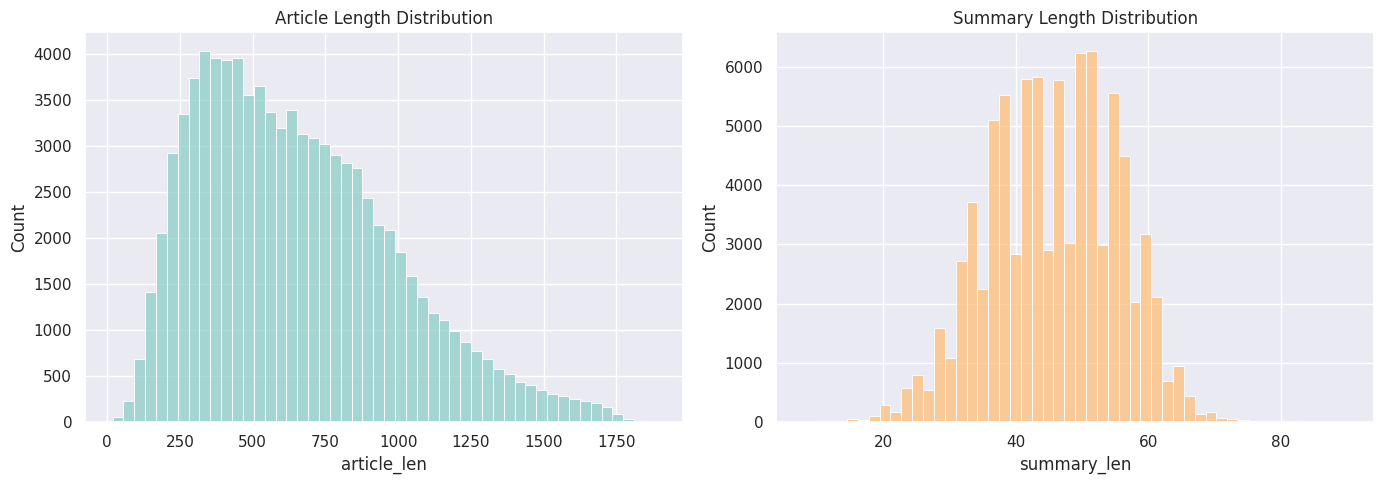

In [24]:
# Length Distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df['article_len'], bins=50, ax=axs[0], color='#8ECFC9')
axs[0].set_title("Article Length Distribution")
sns.histplot(df['summary_len'], bins=50, ax=axs[1], color='#FFBE7A')
axs[1].set_title("Summary Length Distribution")
plt.tight_layout()
plt.show()

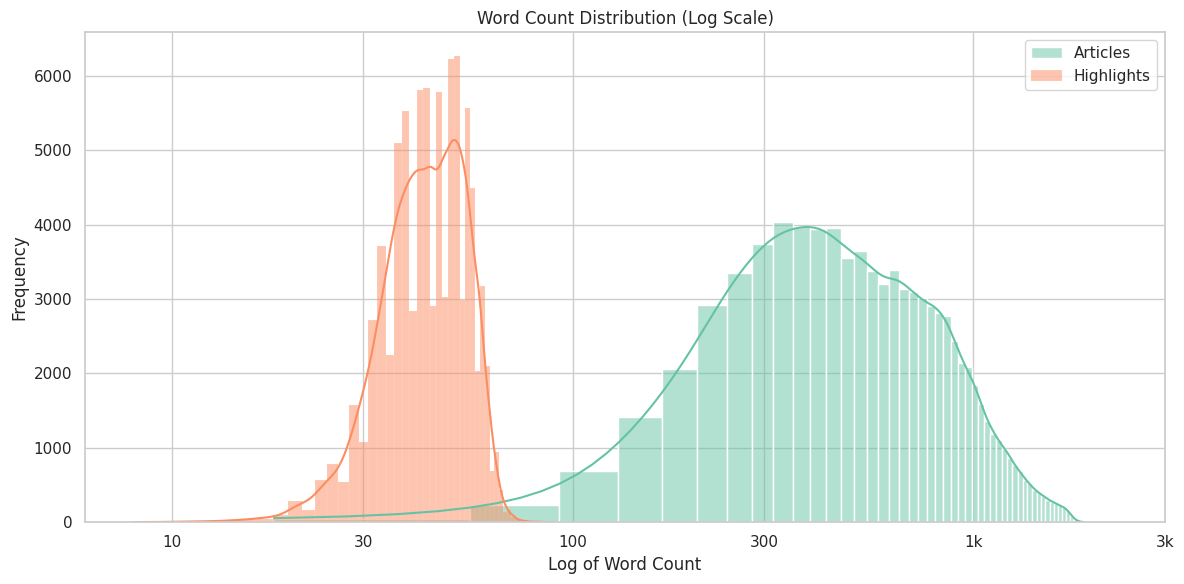

In [27]:
# Length distribution with log scale and labeled x-axis
fig, ax1 = plt.subplots(figsize=(12, 6))
article_lengths = df['article'].apply(lambda x: len(x.split()))
highlight_lengths = df['highlights'].apply(lambda x: len(x.split()))

sns.histplot(article_lengths, bins=50, kde=True, color='#66c2a5', ax=ax1, label='Articles')
sns.histplot(highlight_lengths, bins=50, kde=True, color='#fc8d62', ax=ax1, label='Highlights')
ax1.set(xscale="log")
ax1.set_title("Word Count Distribution (Log Scale)")
ax1.set_xlabel("Log of Word Count")
ax1.set_ylabel("Frequency")
ax1.set_xticks([10, 30, 100, 300, 1000, 3000])
ax1.set_xticklabels(['10', '30', '100', '300', '1k', '3k'])
plt.legend()
plt.tight_layout()
plt.show()


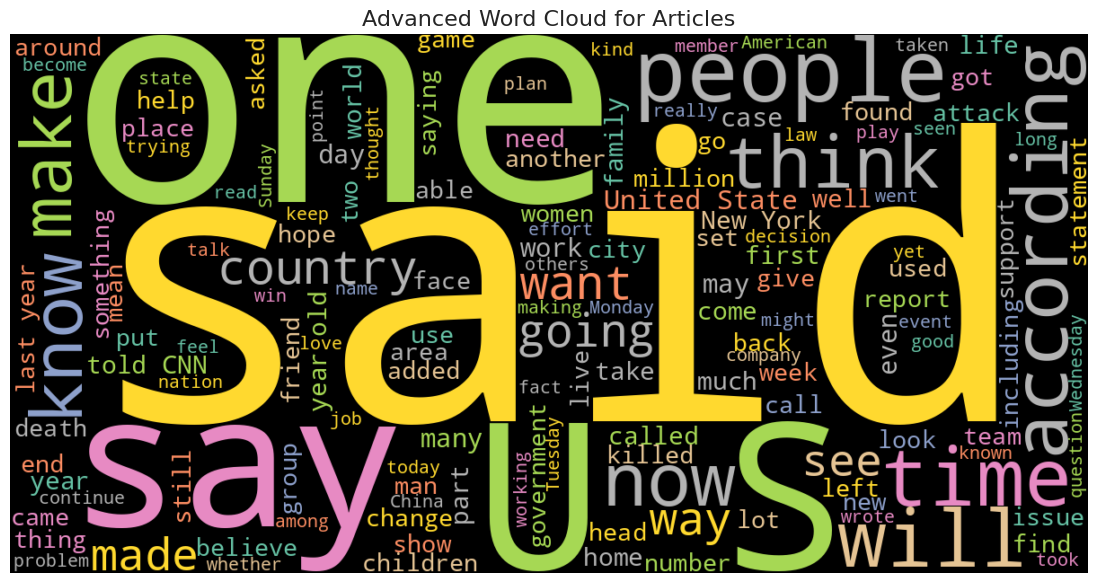

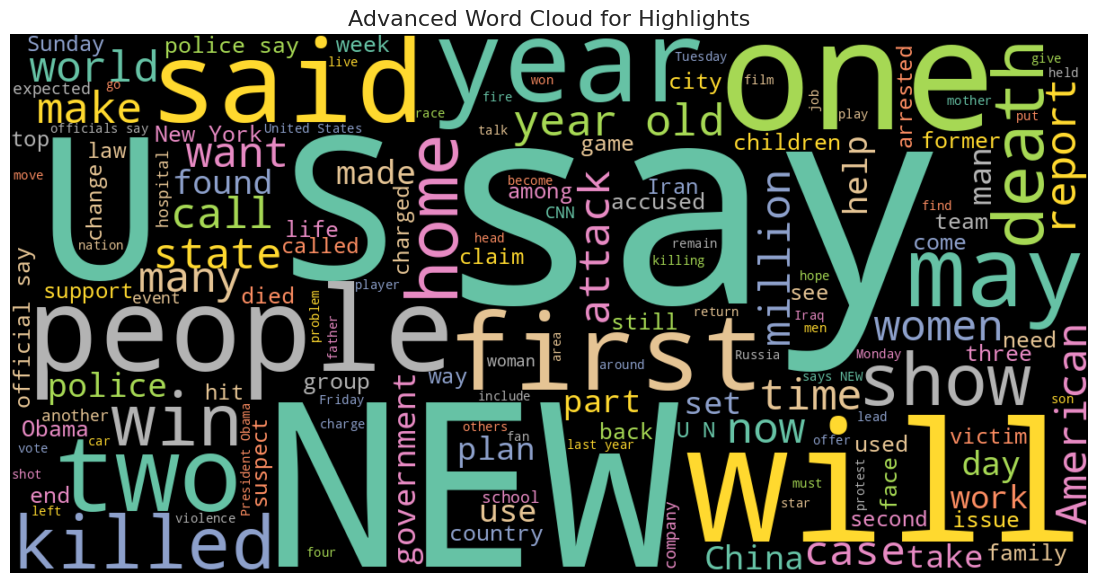

In [28]:
# Word cloud with color mask and more contrast
def plot_advanced_wordcloud(text_series, title):
    text = ' '.join(text_series.dropna())
    wordcloud = WordCloud(width=1200, height=600,
                          max_words=150,
                          background_color='black',
                          colormap='Set2').generate(text)
    plt.figure(figsize=(14, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

plot_advanced_wordcloud(df['article'], 'Advanced Word Cloud for Articles')
plot_advanced_wordcloud(df['highlights'], 'Advanced Word Cloud for Highlights')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-30-fa1ca458ea5d>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


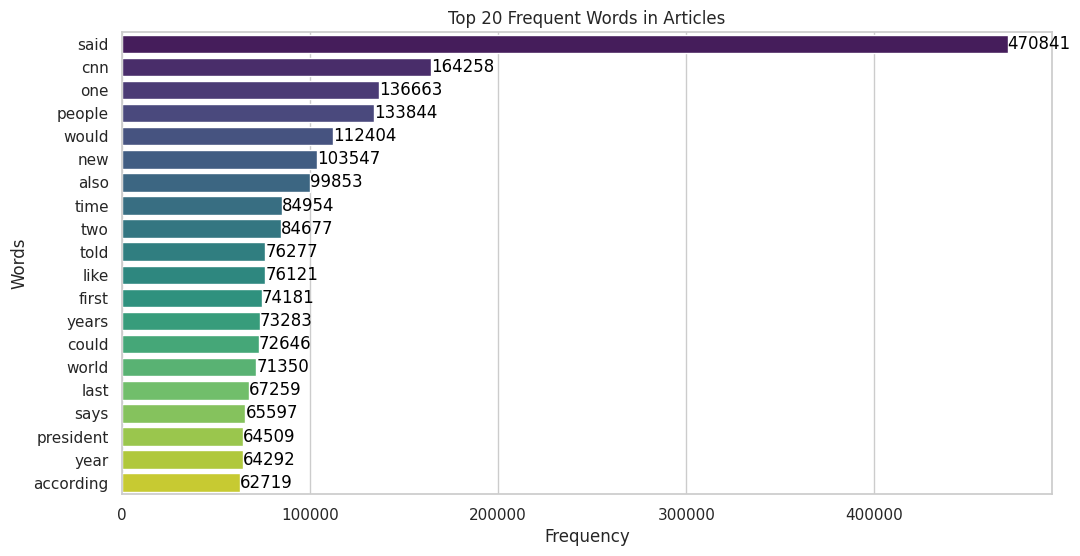

In [30]:
# Most frequent words annotated and sorted
nltk.download('stopwords') # Download stopwords if not already downloaded
stop_words = set(stopwords.words('english'))
words = word_tokenize(' '.join(df['article'].values))
words = [w.lower() for w in words if w.isalnum() and w.lower() not in stop_words]
fdist = FreqDist(words)
common = fdist.most_common(20)
words, freqs = zip(*common)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), palette='viridis')
plt.title("Top 20 Frequent Words in Articles")
for i, v in enumerate(freqs):
    plt.text(v + 5, i, str(v), color='black', va='center')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

<ipython-input-32-bc6cbcd0569d>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=words, palette='crest')


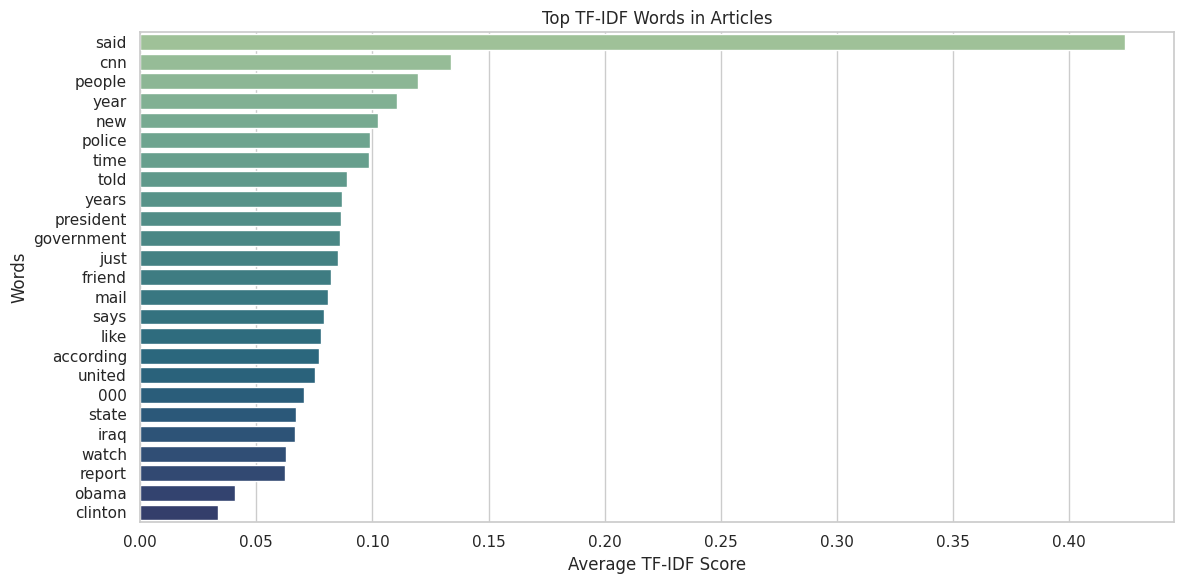

In [32]:
# TF-IDF with word grouping
tfidf = TfidfVectorizer(max_features=25, stop_words='english')
X = tfidf.fit_transform(df['article'][:1000])
tfidf_scores = np.asarray(X.mean(axis=0)).flatten()
words = tfidf.get_feature_names_out()

sorted_idx = np.argsort(tfidf_scores)[::-1]
words = [words[i] for i in sorted_idx]
scores = [tfidf_scores[i] for i in sorted_idx]

plt.figure(figsize=(12, 6))
sns.barplot(x=scores, y=words, palette='crest')
plt.title("Top TF-IDF Words in Articles")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


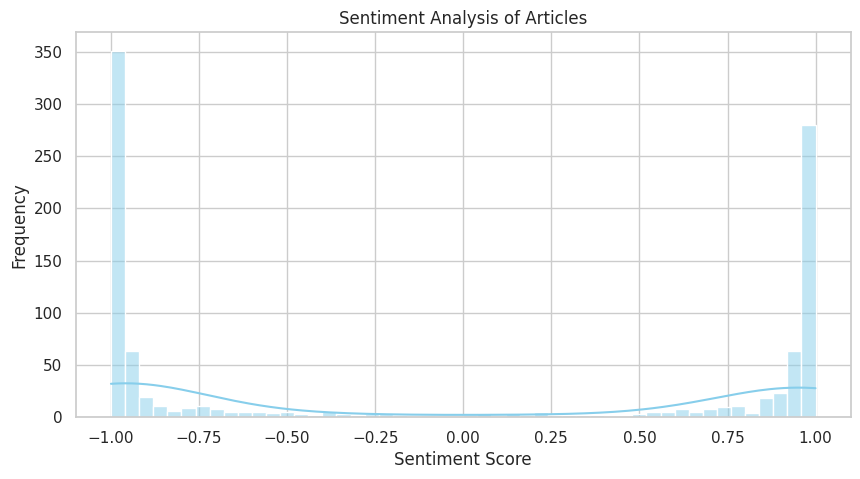

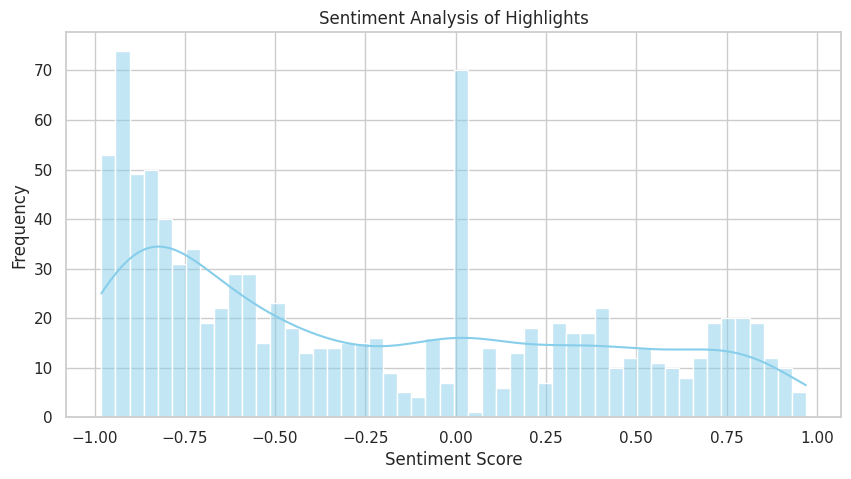

In [34]:
#Sentimental Analysis of Articles and Summaries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Sentiment Analysis Function
def plot_sentiment_analysis(text_series, title, sample_size=1000):
    sid = SentimentIntensityAnalyzer()
    text_sample = text_series[:sample_size].astype(str)
    sentiments = text_sample.apply(lambda x: sid.polarity_scores(x)['compound'])
    plt.figure(figsize=(10, 5))
    sns.histplot(sentiments, bins=50, kde=True, color='skyblue')
    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()

plot_sentiment_analysis(df['article'], 'Sentiment Analysis of Articles')
plot_sentiment_analysis(df['highlights'], 'Sentiment Analysis of Highlights')

<ipython-input-35-fb0b7ff5d0c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')


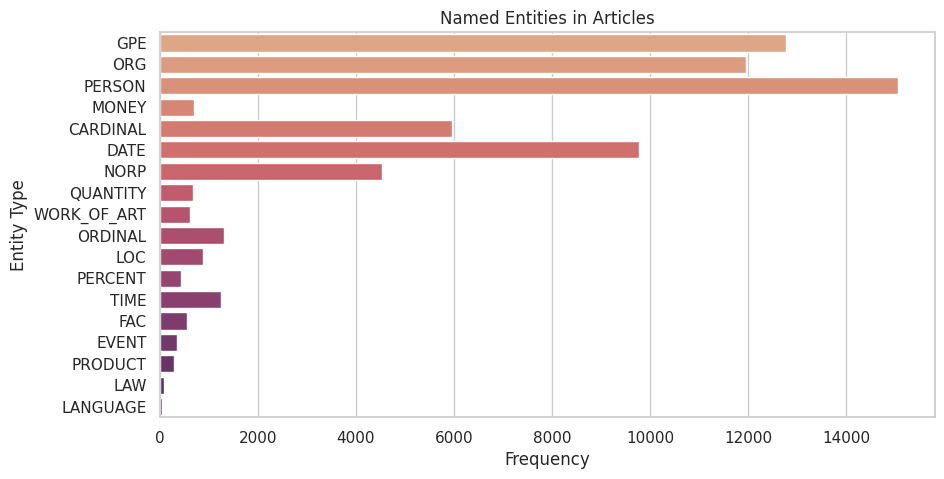

<ipython-input-35-fb0b7ff5d0c0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')


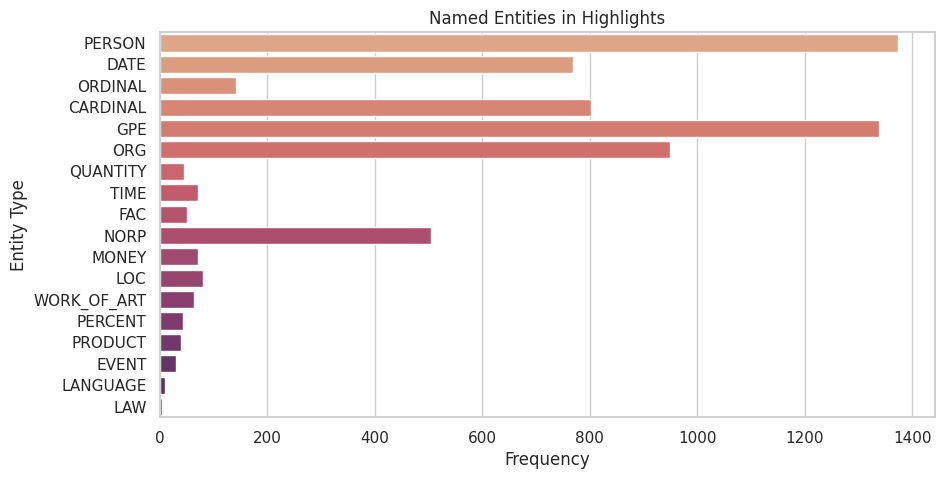

In [35]:
# Named Entity Plot Function
def plot_named_entities(text_series, title, batch_size=100):
    entity_counts = Counter()
    for i in range(0, min(len(text_series), 1000), batch_size):
        text_sample = " ".join(text_series[i : i + batch_size])
        doc = nlp(text_sample)
        entity_counts.update(ent.label_ for ent in doc.ents)

    if entity_counts:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(entity_counts.values()), y=list(entity_counts.keys()), palette='flare')
        plt.title(title)
        plt.xlabel('Frequency')
        plt.ylabel('Entity Type')
        plt.show()
    else:
        print(f"No named entities found in the provided text for {title}.")

plot_named_entities(df['article'], 'Named Entities in Articles')
plot_named_entities(df['highlights'], 'Named Entities in Highlights')


<ipython-input-36-863e3654ad2c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_counts.values()), y=list(pos_counts.keys()), palette='crest')


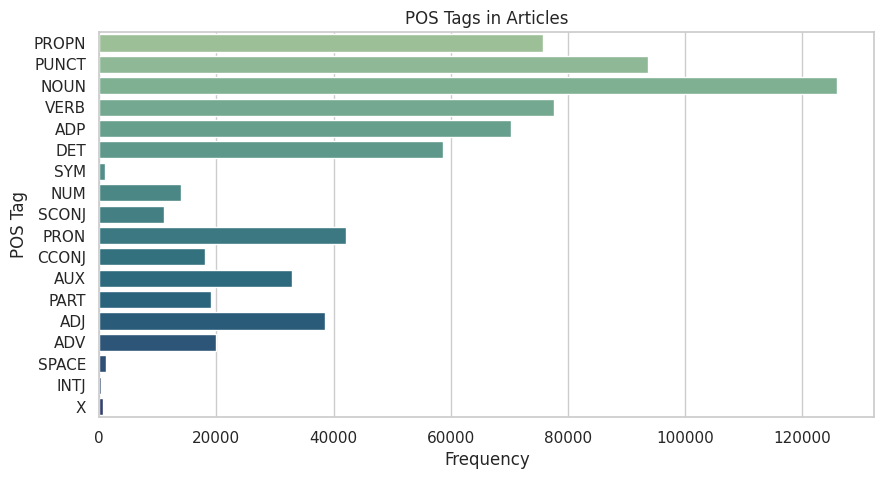

<ipython-input-36-863e3654ad2c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_counts.values()), y=list(pos_counts.keys()), palette='crest')


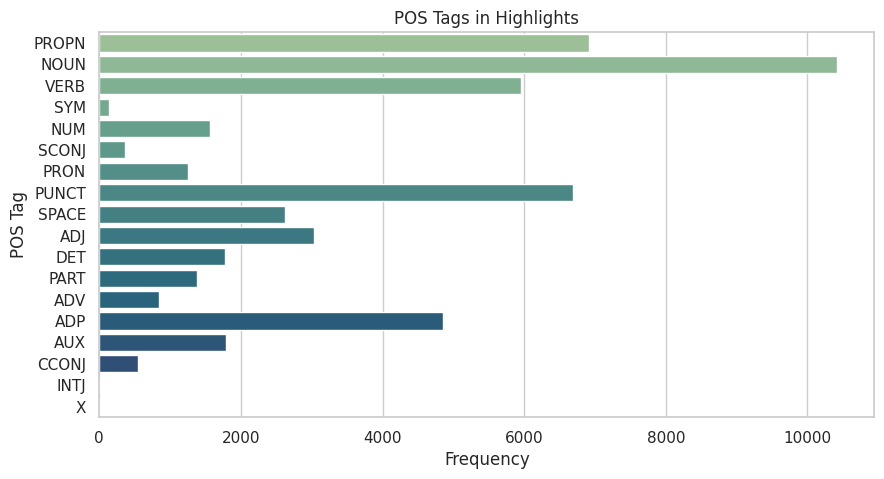

In [36]:
# POS Tag Plot Function
def plot_pos_tags(text_series, title, batch_size=100):
    pos_counts = Counter()
    for i in range(0, min(len(text_series), 1000), batch_size):
        text_batch = " ".join(text_series[i : i + batch_size])
        doc = nlp(text_batch)
        pos_counts.update(token.pos_ for token in doc)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(pos_counts.values()), y=list(pos_counts.keys()), palette='crest')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('POS Tag')
    plt.show()

plot_pos_tags(df['article'], 'POS Tags in Articles')
plot_pos_tags(df['highlights'], 'POS Tags in Highlights')


<ipython-input-37-b81d72ba85a8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")


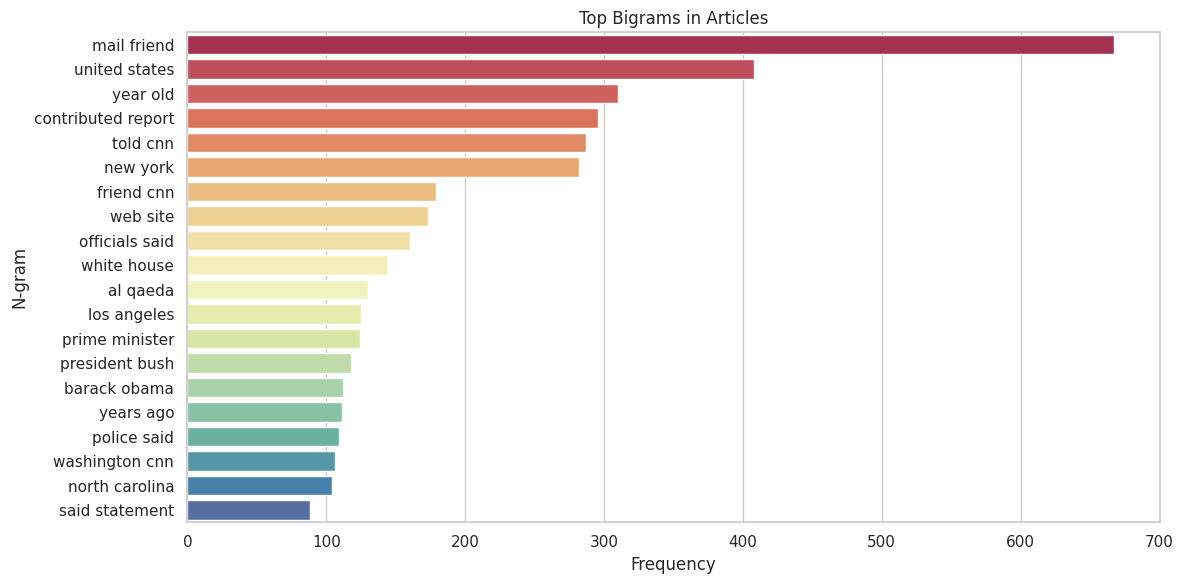

<ipython-input-37-b81d72ba85a8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")


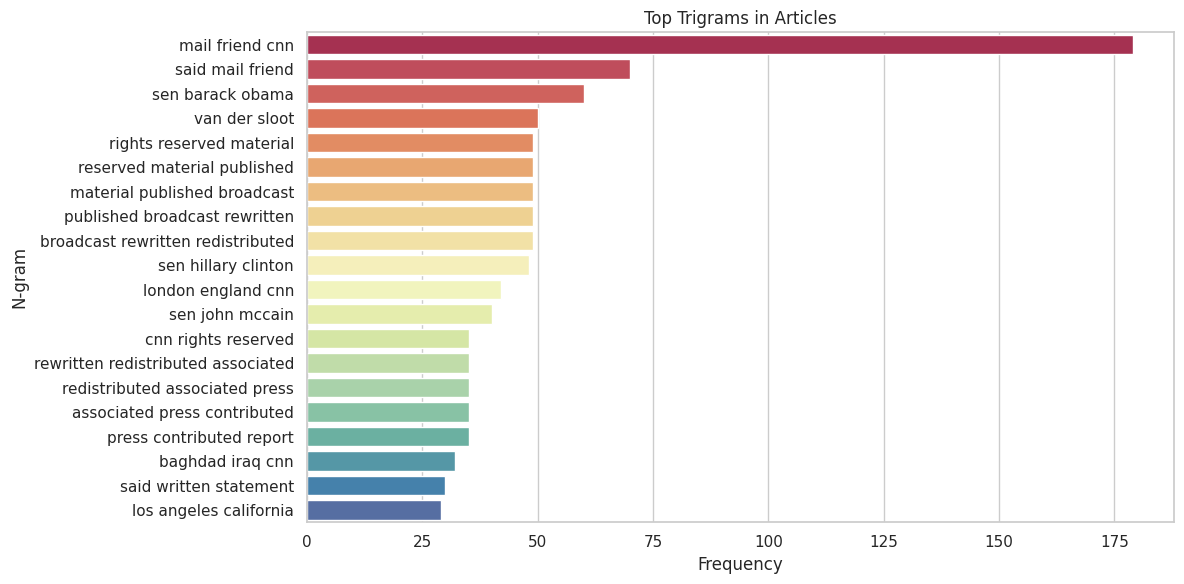

In [37]:
# N-gram Frequency Plot Function
def plot_top_ngrams(text_series, ngram_range=(2, 2), top_n=20, title="Top N-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(text_series)
    bag_of_words = vec.transform(text_series)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    sorted_words = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    ngrams, counts = zip(*sorted_words)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(counts), y=list(ngrams), palette="Spectral")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("N-gram")
    plt.tight_layout()
    plt.show()

# Apply for bigrams and trigrams
plot_top_ngrams(df['article'].dropna().astype(str)[:1000], ngram_range=(2, 2), title="Top Bigrams in Articles")
plot_top_ngrams(df['article'].dropna().astype(str)[:1000], ngram_range=(3, 3), title="Top Trigrams in Articles")


In [47]:
import re
import string
import numpy as np
import networkx as nx
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[(.*?)\]', '', text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.strip()

def textrank_summarize(text, num_sentences=3):
    sentences = sent_tokenize(text)
    cleaned = [clean_text(sent) for sent in sentences]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned)
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    np.fill_diagonal(similarity_matrix, 0)
    graph = nx.from_numpy_array(similarity_matrix)
    scores = nx.pagerank(graph)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    return " ".join([s for _, s in ranked_sentences[:num_sentences]])

def lsa_summarize(text, num_sentences=3):
    sentences = sent_tokenize(text)
    cleaned = [clean_text(sent) for sent in sentences]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned)
    svd = TruncatedSVD(n_components=1)
    scores = svd.fit_transform(tfidf_matrix)
    ranked = sorted(((score, s) for score, s in zip(scores, sentences)), reverse=True)
    return " ".join([s for _, s in ranked[:num_sentences]])


In [45]:
# 🧠 Train and Save LSTM Text Summarization Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load pre-cleaned dataset (2000 samples)
df = pd.read_csv("cleaned_cnn_lstm_subset.csv")
df['clean_summary'] = df['clean_summary'].apply(lambda x: "starttoken " + x + " endtoken")

# Parameters
VOCAB_SIZE = 10000
MAX_INPUT_LEN = 400
MAX_SUMMARY_LEN = 50

# Prepare inputs and summaries
input_texts = df['clean_article'].astype(str)
target_texts = df['clean_summary'].astype(str)

# Tokenize
input_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
target_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

input_seq = pad_sequences(input_tokenizer.texts_to_sequences(input_texts), maxlen=MAX_INPUT_LEN, padding='post')
target_seq = pad_sequences(target_tokenizer.texts_to_sequences(target_texts), maxlen=MAX_SUMMARY_LEN, padding='post')
target_seq = np.expand_dims(target_seq, -1)

# Build simple LSTM model
model = Sequential([
    Embedding(VOCAB_SIZE, 128),
    LSTM(256),
    RepeatVector(MAX_SUMMARY_LEN),
    LSTM(256, return_sequences=True),
    TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
])

# ✅ Force model build to show summary properly
model.build(input_shape=(None, MAX_INPUT_LEN))
model.summary()

# Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(input_seq, target_seq, batch_size=64, epochs=2, validation_split=0.1)

# Save model and tokenizers
model.save("lstm_summarizer_model.h5")
with open("lstm_tokenizers.pkl", "wb") as f:
    pickle.dump((input_tokenizer, target_tokenizer), f)

print("✅ Model and tokenizers saved!")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 400, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_1 (RepeatVector)       │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50, 256)             │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 50, 10000)           │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,769,552 (18.19 MB)

 Trainable params: 4,769,552 (18.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 148s 5s/step - loss: 7.9387 - val_loss: 5.3068
Epoch 2/2
29/29 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - loss: 5.5123 - val_loss: 5.1032


✅ Model and tokenizers saved!


In [46]:
# pegasus_summarizer_inference.py
import pandas as pd
from transformers import PegasusTokenizer, PegasusForConditionalGeneration

# Load cleaned test data (subset)
df = pd.read_csv("cleaned_cnn_lstm_subset.csv").sample(100, random_state=42)
articles = df['clean_article'].tolist()

# Load pretrained PEGASUS model
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-cnn_dailymail")
model = PegasusForConditionalGeneration.from_pretrained("google/pegasus-cnn_dailymail")

# Summarization function
def summarize(text):
    inputs = tokenizer([text], return_tensors="pt", truncation=True, max_length=512)
    summary_ids = model.generate(inputs["input_ids"], max_length=64, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries
summaries = [summarize(article) for article in articles]

# Save results
df_result = df.copy()
df_result["pegasus_summary"] = summaries
df_result.to_csv("pegasus_pretrained_inference.csv", index=False)
print("✅ Inference complete. Summaries saved to 'pegasus_pretrained_inference.csv'")

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

✅ Inference complete. Summaries saved to 'pegasus_pretrained_inference.csv'


In [1]:
#CNN Model Training
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, RepeatVector, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load cleaned dataset
df = pd.read_csv("cleaned_cnn_lstm_subset.csv")
df['clean_summary'] = df['clean_summary'].apply(lambda x: "starttoken " + x + " endtoken")

# Parameters
VOCAB_SIZE = 10000
MAX_INPUT_LEN = 400
MAX_TARGET_LEN = 50

# Tokenization
input_texts = df['clean_article'].astype(str)
target_texts = df['clean_summary'].astype(str)

input_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
target_tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

input_seq = pad_sequences(input_tokenizer.texts_to_sequences(input_texts), maxlen=MAX_INPUT_LEN, padding='post')
target_seq = pad_sequences(target_tokenizer.texts_to_sequences(target_texts), maxlen=MAX_TARGET_LEN, padding='post')
target_seq = np.expand_dims(target_seq, -1)

X_train, X_val, y_train, y_val = train_test_split(input_seq, target_seq, test_size=0.1, random_state=42)

# Define the model
model = Sequential([
    Embedding(VOCAB_SIZE, 128, input_length=MAX_INPUT_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    RepeatVector(MAX_TARGET_LEN),
    LSTM(256, return_sequences=True),
    TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
])

# ✅ Build the model before summary to get full output shapes and param counts
model.build(input_shape=(None, MAX_INPUT_LEN))

# Show the proper summary
model.summary()

# Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop])

NameError: name 'pd' is not defined

In [ ]:
#CNN Summary Generation Function

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load model & tokenizer
model = load_model("cnn_summarizer_model.h5")
with open("cnn_tokenizers.pkl", "rb") as f:
    input_tokenizer, target_tokenizer = pickle.load(f)

index_to_word = {i: w for w, i in target_tokenizer.word_index.items()}

# Summary generation function
def cnn_generate_summary(input_text):
    sequence = input_tokenizer.texts_to_sequences([input_text])
    padded = pad_sequences(sequence, maxlen=400, padding='post')
    prediction = model.predict(padded)[0]
    predicted_ids = prediction.argmax(axis=1)
    words = [index_to_word.get(i, '') for i in predicted_ids]
    summary = []
    for word in words:
        if word == 'endtoken': break
        if word and word != 'starttoken': summary.append(word)
    return ' '.join(summary)

In [ ]:
#Full Model Comparison Function
from extractive_models import textrank_summarize, lsa_summarize
from lstm_model import generate_summary as lstm_summary
from transformer_utils import predict_transformer_summary

def compare_summaries(article_text):
    return {
        "TextRank": textrank_summarize(article_text),
        "LSA": lsa_summarize(article_text),
        "LSTM": lstm_summary(article_text),
        "Transformer": predict_transformer_summary(article_text),
        "CNN": cnn_generate_summary(article_text)
    }

In [ ]:
#ROUGE Evaluation + Ranking
from rouge_score import rouge_scorer

def evaluate_summaries(summary_dict, reference_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {}
    for model_name, summary in summary_dict.items():
        result = scorer.score(reference_summary, summary)
        scores[model_name] = {
            'ROUGE-1': result['rouge1'].fmeasure,
            'ROUGE-2': result['rouge2'].fmeasure,
            'ROUGE-L': result['rougeL'].fmeasure
        }
    return scores

def rank_models(rouge_scores):
    ranked = []
    for model, scores in rouge_scores.items():
        avg = sum(scores.values()) / len(scores)
        ranked.append((model, avg))
    ranked.sort(key=lambda x: x[1], reverse=True)
    return ranked

In [ ]:
#Plotting + Example Execution

import matplotlib.pyplot as plt
import pandas as pd

def plot_rouge_scores(rouge_scores):
    df = pd.DataFrame(rouge_scores).T
    df.plot(kind='bar', figsize=(10, 6))
    plt.title("ROUGE Scores by Model")
    plt.ylabel("F1 Score")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run example
df = pd.read_csv("cleaned_cnn_lstm_subset.csv")
article = df['clean_article'].iloc[0]
reference = df['clean_summary'].iloc[0]

summaries = compare_summaries(article)
rouge = evaluate_summaries(summaries, reference)
ranked = rank_models(rouge)

# Print
for model, summary in summaries.items():
    print(f"\n🧠 {model}:\n{summary}\n{'-'*80}")

print("\n📊 ROUGE Scores:")
for model, score in rouge.items():
    print(f"{model}: {score}")

print("\n🏆 Ranked Models:")
for i, (model, score) in enumerate(ranked, 1):
    print(f"{i}. {model} - Avg ROUGE: {score:.4f}")

plot_rouge_scores(rouge)
